In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-summary/news_summary_more.csv
/kaggle/input/news-summary/news_summary.csv


In [2]:
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, T5ForConditionalGeneration, T5TokenizerFast
import torch
import seaborn as sns

In [3]:
data=pd.read_csv("/kaggle/input/news-summary/news_summary_more.csv",encoding="latin-1")
data=pd.read_csv("/kaggle/input/news-summary/news_summary.csv",encoding="latin-1")

In [4]:
data.iloc[0]["ctext"]

'The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues,? the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications ? one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) ? were issued by the Dama

In [5]:
data.iloc[0]["text"]

'The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.'

In [6]:
data.head(5)

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [7]:
data=data[["ctext","text"]]

In [8]:
data=data.dropna()

In [9]:
data.head()

,ctext,text
0,The Daman and Diu administration on Wednesday ...,The Administration of Union Territory Daman an...
1,"From her special numbers to TV?appearances, Bo...",Malaika Arora slammed an Instagram user who tr...
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Mumbai and other Indian cities are t...,Hotels in Maharashtra will train their staff t...


In [10]:
len(data)

4396

In [11]:
test_data=data.iloc[:677].reset_index()[["ctext","text"]]
train_data=data.iloc[677:].reset_index()[["ctext","text"]]

In [12]:
test_data.head()

,ctext,text
0,The Daman and Diu administration on Wednesday ...,The Administration of Union Territory Daman an...
1,"From her special numbers to TV?appearances, Bo...",Malaika Arora slammed an Instagram user who tr...
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Mumbai and other Indian cities are t...,Hotels in Maharashtra will train their staff t...


In [13]:
mx,mn=0,20000
for i in range(len(train_data)):
    mx=max(len(train_data.iloc[i]["ctext"].split(" ")),mx)
    mn=min(len(train_data.iloc[i]["ctext"].split(" ")),mn)
   
print(f"Range summary: {mn}-{mx}")

Range summary: 2-12201


In [14]:
mx,mn=0,20000
for i in range(len(train_data)):
    mx=max(len(train_data.iloc[i]["text"].split(" ")),mx)
    mn=min(len(train_data.iloc[i]["text"].split(" ")),mn)

print(f"Range summary: {mn}-{mx}")

Range summary: 44-62


In [15]:
train_data["ctext_len"]=train_data['ctext'].apply(lambda x:len(x.split()))
train_data["text_len"]=train_data["text"].apply(lambda x:len(x.split()))

In [16]:
train_data["ctext_len"]

0       478
1       912
2       266
3       432
4       348
       ... 
3714    177
3715    140
3716    658
3717    210
3718    259
Name: ctext_len, Length: 3719, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='ctext_len', ylabel='Count'>

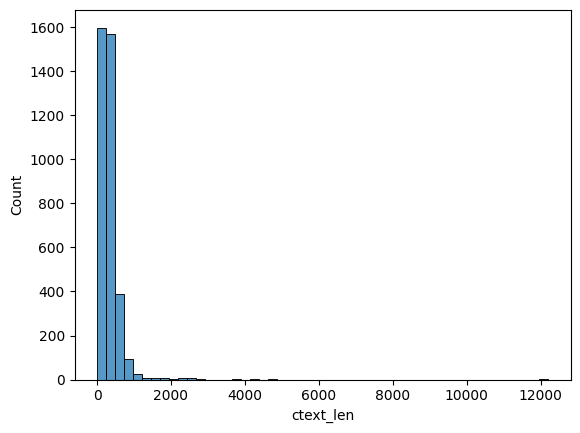

In [17]:
sns.histplot(train_data["ctext_len"],bins=50)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='text_len', ylabel='Count'>

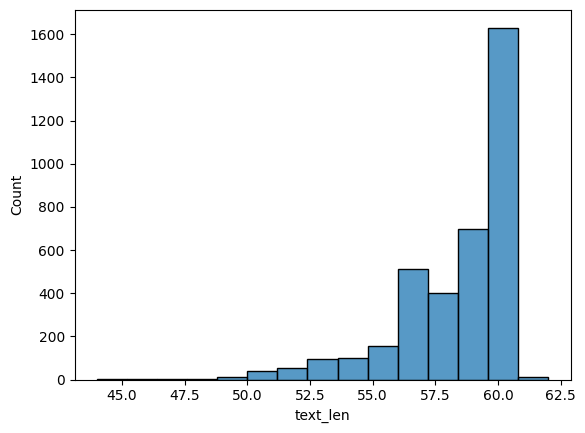

In [18]:
sns.histplot(train_data["text_len"],bins=15)

In [19]:
class NewsDataset(Dataset):
    def __init__(self,data1,tokenizer,max_elength,max_olength):
        self.data=data1
        self.tokenizer=tokenizer
        self.max_elength=max_elength
        self.max_olength=max_olength
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,id):
        
        text=self.data.iloc[id]["ctext"]
        summary=self.data.iloc[id]["text"]
        
        encoder=self.tokenizer(text, 
            max_length=self.max_elength,
            padding="max_length",
            truncation=True,
            return_tensors="pt")
        
        decoder=self.tokenizer(summary,
            max_length=self.max_olength,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        
        return {
            "text":text,
            "summary":summary,
            "encoder_ids":encoder["input_ids"].squeeze(),
            "encoder_attention_mask":encoder["attention_mask"].squeeze(),
            "decoder_ids":decoder["input_ids"].squeeze(),
            "decoder_attention_mask":decoder["attention_mask"].squeeze()
        }

In [20]:
model_name="google-t5/t5-base"

tokenizer=T5TokenizerFast.from_pretrained(model_name)
model=T5ForConditionalGeneration.from_pretrained(model_name)

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [21]:
train_dataset=NewsDataset(train_data,tokenizer,512,128)
test_dataset=NewsDataset(test_data,tokenizer,512,128)

In [22]:
(len(train_dataset),len(test_dataset))

(3719, 677)

In [24]:
train_dataset[0]

{'text': 'A £14bn class-action lawsuit against MasterCard for allegedly overcharging more than 45 million people in Britain over a 16-year period was blocked by a British court on Friday. The competition appeal tribunal (CAT), a newly empowered court that oversees Britain?s fledgling class action regime, ruled that it would not grant the necessary collective proceedings order for the case to continue to trial. Had it been allowed to proceed, the case would have been the largest and most complex in British legal history and would have tested the limits of the new Consumer Rights Act, which introduced US-style ?opt-out? collective class actions for breaches of UK or European Union competition law in 2015. MasterCard welcomed the judgment, saying the claim was ?completely unsuitable? to be brought under the collective action regime.A law firm, Quinn Emanuel Urquhart & Sullivan, launched the case on behalf of adults in Britain after MasterCard lost a drawn-out appeal against a 2007 Europea

In [25]:
test_dataset[0]

{'text': 'The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues,? the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications ? one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) ? were issued by

In [26]:
train_dataloader=DataLoader(train_dataset,batch_size=8,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=8,shuffle=False)

In [27]:
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.0005)

In [28]:
torch.cuda.empty_cache()
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()
with torch.no_grad():
    for _,batch in enumerate(test_dataloader):
        y=batch["decoder_ids"].to(device,dtype=torch.long)
        y_ids=y[:, :-1].contiguous()
        labels=y[:, 1:].clone().detach()
        labels[y[:, 1:]==tokenizer.pad_token_id]=-100
        ids = batch['encoder_ids'].to(device, dtype=torch.long)
        mask = batch['encoder_attention_mask'].to(device, dtype=torch.long)
        
        outputs=model(input_ids=ids,attention_mask=mask,decoder_input_ids=y_ids,labels=labels)
        loss=outputs[0]
        
        print(f"Batch:{_}")
        print(f"Loss:{loss}")
        if _==10:
            break
            

Batch:0
Loss:6.469070911407471
Batch:1
Loss:6.818984508514404
Batch:2
Loss:6.1272382736206055
Batch:3
Loss:6.6297383308410645
Batch:4
Loss:6.586476802825928
Batch:5
Loss:6.768886566162109
Batch:6
Loss:6.137417793273926
Batch:7
Loss:6.0332183837890625
Batch:8
Loss:6.638702869415283
Batch:9
Loss:5.921916961669922
Batch:10
Loss:5.808637619018555


In [29]:
epochs=15
torch.cuda.empty_cache()
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer.zero_grad()

for epoch in range(epochs):
    
    model.train()
    print(f"Epoch:{epoch+1}")
    print()
    for _,batch in enumerate(train_dataloader):
        y=batch["decoder_ids"].to(device,dtype=torch.long)
        y_ids=y[:, :-1].contiguous()
        labels=y[:, 1:].clone().detach()
        labels[y[:, 1:]==tokenizer.pad_token_id]=-100
        ids = batch['encoder_ids'].to(device, dtype=torch.long)
        mask = batch['encoder_attention_mask'].to(device, dtype=torch.long)
        
        outputs=model(input_ids=ids,attention_mask=mask,decoder_input_ids=y_ids,labels=labels)
        loss=outputs[0]
        
        if _%100==0 and _>0:
            print(f"Step:{_}")
            print(f"Training Loss:{loss.item()}")
            print()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch:1

Step:100
Training Loss:1.4055367708206177

Step:200
Training Loss:1.6268677711486816

Step:300
Training Loss:1.7049522399902344

Step:400
Training Loss:1.7231651544570923

Epoch:2

Step:100
Training Loss:1.6362135410308838

Step:200
Training Loss:1.3917261362075806

Step:300
Training Loss:1.1554077863693237

Step:400
Training Loss:1.3053957223892212

Epoch:3

Step:100
Training Loss:1.2456281185150146

Step:200
Training Loss:0.8449190855026245

Step:300
Training Loss:1.3074532747268677

Step:400
Training Loss:1.189422369003296

Epoch:4

Step:100
Training Loss:1.1032947301864624

Step:200
Training Loss:1.106459140777588

Step:300
Training Loss:1.0914040803909302

Step:400
Training Loss:1.0380821228027344

Epoch:5

Step:100
Training Loss:0.7216678857803345

Step:200
Training Loss:0.8772768378257751

Step:300
Training Loss:0.8487212657928467

Step:400
Training Loss:0.8746305704116821

Epoch:6

Step:100
Training Loss:0.8065980076789856

Step:200
Training Loss:0.5406186580657959

St

In [30]:
model.eval()
with torch.no_grad():
    for _,batch in enumerate(test_dataloader):
        y=batch["decoder_ids"].to(device,dtype=torch.long)
        y_ids=y[:, :-1].contiguous()
        labels=y[:, 1:].clone().detach()
        labels[y[:, 1:]==tokenizer.pad_token_id]=-100
        ids = batch['encoder_ids'].to(device, dtype=torch.long)
        mask = batch['encoder_attention_mask'].to(device, dtype=torch.long)
        
        outputs=model(input_ids=ids,attention_mask=mask,decoder_input_ids=y_ids,labels=labels)
        loss=outputs[0]
        
        print(f"Batch:{_}")
        print(f"Loss:{loss}")
        if _==10:
            break

Batch:0
Loss:2.822648286819458
Batch:1
Loss:3.914499044418335
Batch:2
Loss:2.8691766262054443
Batch:3
Loss:2.180616855621338
Batch:4
Loss:3.1864826679229736
Batch:5
Loss:2.063917636871338
Batch:6
Loss:2.2436153888702393
Batch:7
Loss:2.5088911056518555
Batch:8
Loss:3.0007145404815674
Batch:9
Loss:2.2310197353363037
Batch:10
Loss:2.8816332817077637


In [31]:
test_dataloader=DataLoader(test_dataset,batch_size=1,shuffle=False)

In [32]:
model.eval()
torch.cuda.empty_cache()
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

predictions=[]
actuals=[]
for _,batch in enumerate(test_dataloader):
    y=batch["decoder_ids"].to(device,dtype=torch.long)
    y_ids=y[:, :-1].contiguous()
    labels=y[:, 1:].clone().detach()
    ids = batch['encoder_ids'].to(device, dtype=torch.long)
    mask = batch['encoder_attention_mask'].to(device, dtype=torch.long)
    
    generated_ids=model.generate(
        input_ids=ids,
        attention_mask=mask,
        min_length=20,
        max_length=150, 
        num_beams=2,
        repetition_penalty=2.5, 
        length_penalty=1.0, 
    )
    preds=[tokenizer.decode(curr_id,skip_special_tokens=True,
                            clean_up_tokenization_spaces=True) for curr_id in generated_ids]
    target=[tokenizer.decode(curr_id,skip_special_tokens=True,
                            clean_up_tokenization_spaces=True) for curr_id in labels]
    
    predictions.extend(preds)
    actuals.extend(target)
    if _%100==0 and _>0:
        break
    

In [38]:
print("Predictions:")
print(predictions[1])
print("Actuals:")
print(actuals[1])

Predictions:
Earlier, Malaika Arora was trolled for using her 'alumni' (alimony) money to wear short clothes and going to gym. The comment was made by a follower, who shared the picture on Instagram. The actress said that she is extremely excited to be affiliated with Khanna Jewellers.
Actuals:
aika Arora slammed an Instagram user who trolled her for "divorcing a rich man" and "having fun with the alimony". "Her life now is all about wearing short clothes, going to gym or salon, enjoying vacation[s]," the user commented. Malaika responded, "You certainly got to get your damn facts right before spewing sh*t on me...when you know nothing about me."


In [51]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.7 MB/s eta 0:00:00


In [52]:
from evaluate import load
import evaluate

In [53]:
rouge = evaluate.load('rouge')
results = rouge.compute(predictions=predictions, references=actuals)
print(results)

{'rouge1': 0.46980937631841935, 'rouge2': 0.23755230846079656, 'rougeL': 0.33366274471149027, 'rougeLsum': 0.33323747468534826}
